# **RL Portfolio Optimiser: Reinforcement Learning for Financial Portfolio Optimisation**

This project presents a comprehensive reinforcement learning framework to optimise financial portfolio allocation by combining classical Modern Portfolio Theory with advanced RL techniques, specifically Proximal Policy Optimisation (PPO).

It covers the full workflow: data acquisition, classical mean-variance portfolio optimisation, development of a custom OpenAI Gymnasium environment, RL agent training, and rigorous performance evaluation through backtesting.

The following steps are covered:

1. Download and prepare financial data
2. Classical optimisation using Markowitz's theory
3. Construction of a custom RL environment
4. Training an RL agent (PPO)
5. Comparison of results
6. Backtesting and evaluation


In [ ]:
# Install required packages
!pip install yfinance stable-baselines3 gymnasium pandas matplotlib

## Step 1: Download Financial Data

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define stock tickers and download historical prices
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
data = yf.download(tickers, start="2020-01-01", end="2022-01-01")["Close"]
daily_returns = data.pct_change().dropna()
expected_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

data.head()

/tmp/ipython-input-1150173370.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2022-01-01")["Close"]
[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2020-01-02,72.620827,94.900497,68.026024,153.042297,28.684000
2020-01-03,71.914818,93.748497,67.670151,151.136673,29.534000
2020-01-06,72.487862,95.143997,69.473846,151.527283,30.102667
2020-01-07,72.146935,95.343002,69.339645,150.145721,31.270666
2020-01-08,73.307503,94.598503,69.833183,152.537277,32.809334


## Step 2: Classical Portfolio Optimisation

Using Markowitz Modern Portfolio Theory to minimise risk (portfolio variance).

Optimised Weights: [0.67452007 0.05       0.11082314 0.08560249 0.0790543 ]
Expected Return: 0.002243819044867688
Portfolio Variance: 0.00047961735654809964


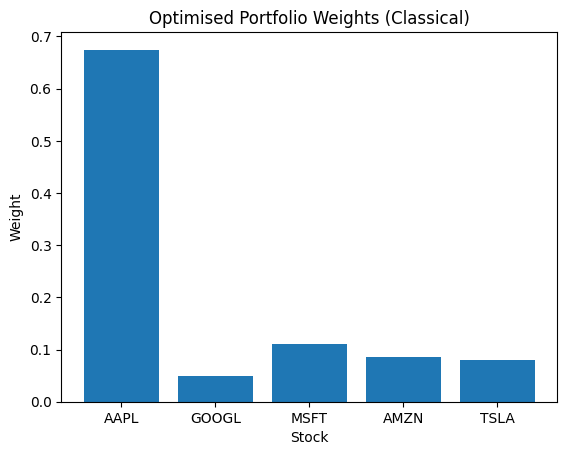

In [ ]:
from scipy.optimize import minimize

def compute_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def constraint(weights):
    return np.sum(weights) - 1

bounds = [(0, 1)] * len(tickers)
initial_weights = np.random.dirichlet(np.ones(len(tickers)), size=1).flatten()

constraints = [
    {'type': 'eq', 'fun': constraint},
    {'type': 'ineq', 'fun': lambda w: w - 0.05}
]

result = minimize(compute_portfolio_variance, initial_weights, args=(cov_matrix,),
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimized_weights = result.x
portfolio_return = np.dot(expected_returns, optimized_weights)
portfolio_variance_value = compute_portfolio_variance(optimized_weights, cov_matrix)

print("Optimised Weights:", optimized_weights)
print("Expected Return:", portfolio_return)
print("Portfolio Variance:", portfolio_variance_value)

# Plot
plt.bar(tickers, optimized_weights)
plt.title("Optimised Portfolio Weights (Classical)")
plt.xlabel("Stock")
plt.ylabel("Weight")
plt.show()

## Step 3: Create a Custom RL Environment
This environment simulates portfolio allocation over time.

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class PortfolioEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, returns, initial_balance=1000):
        super(PortfolioEnv, self).__init__()
        self.returns = returns.values.astype(np.float32)  # ensure float32 from the start
        self.n_assets = self.returns.shape[1]
        self.initial_balance = initial_balance
        self.max_steps = len(returns) - 2

        self.action_space = spaces.Box(low=0.05, high=1.0, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.weights = np.ones(self.n_assets, dtype=np.float32) / self.n_assets
        self.nav = self.initial_balance
        observation = self.returns[self.current_step].astype(np.float32)
        return observation, {}

    def step(self, action):
        action = np.clip(action, 0.05, 1.0).astype(np.float32)
        action = action / np.sum(action)

        prev_returns = self.returns[self.current_step]
        self.nav *= (1 + np.dot(prev_returns, self.weights))
        self.weights = action

        self.current_step += 1
        next_returns = self.returns[self.current_step]
        reward = float(np.dot(next_returns, self.weights))

        terminated = self.current_step >= self.max_steps
        truncated = False
        obs = self.returns[self.current_step].astype(np.float32)

        return obs, reward, terminated, truncated, {}

## Step 4: Train PPO Agent on Portfolio Environment

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

env = PortfolioEnv(daily_returns)
check_env(env)

model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=50000)

## Step 5: Evaluate PPO Agent

Final NAV: £4583.61
Mean daily return (RL): 0.00338


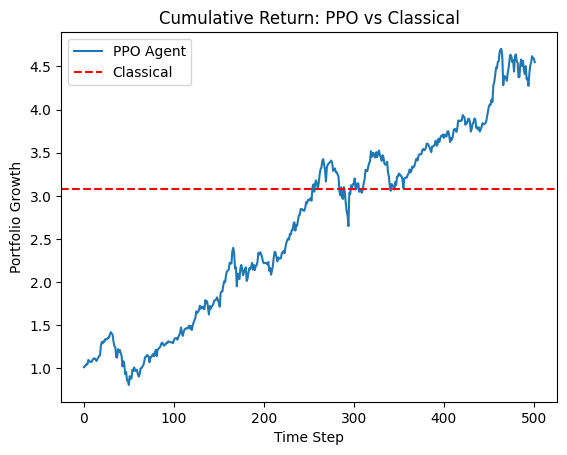

In [ ]:
obs, _ = env.reset()
rewards = []

for _ in range(env.max_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    if terminated or truncated:
        break

print(f"Final NAV: £{env.nav:.2f}")
print(f"Mean daily return (RL): {np.mean(rewards):.5f}")

# Plot performance
plt.plot(np.cumprod(1 + np.array(rewards)), label="PPO Agent")
plt.axhline(y=(1 + portfolio_return) ** len(rewards), color='r', linestyle='--', label="Classical")
plt.title("Cumulative Return: PPO vs Classical")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Growth")
plt.legend()
plt.show()